# 群落生物多样性指数计算

总体目标：
1. 计算物种多样性，比较分析各个多样性指数大小，对比各个群落多样性
2. 分析使用不同变量（四度一量）计算的多样性值的差异；
3. 分析各个地点的植物组成的生活型谱；
4. 对比分析各地点群落结构和生产力的动态变化，以及物种多样性与生产力关系
5. 撰写给定数据的群落多样性分析报告（使用图表）。

说明：多样性指数包括α多样性（计算地点、月份），β多样性(计算一个地点月份间、地点间)，以及不同地点间群落相似性。

结果包括：α多样性，β多样性，群落相似性，不同变量计算的多样性值/指数对比分析，动态变化，生活型谱，多样性与生产力关系


任务拆解：
- 提取数据，从原表格（六个群落，每个群落六个月，包含土壤数据）提取出每一个子表（暂时去除土壤数据后，某群落的某个月物种数据）
- 计算多样性指数，对每一个子表，进行α多样性的计算
- 计算多样性指数，对同一地点不同月份之间进行β多样性分析，计算群落相似度
- 动态变化，将某一群落六个月内的多样性变化进行汇总，绘制一张图表分析物种多样性随月份的动态变化
- 对每个群落进行生活型谱分析
- 计算生物多样性和生产力之间的关系

In [3]:
from openpyxl import load_workbook  
import numpy as np 
import pandas as pd  

In [4]:
# pd.set_option('display.precision', 2)  
"""
伏笔，不要用上面这行
因为就算设置了两位小数，也无法阻止pandas对于过大/过小的数进行科学计数法表示的行为
可以直接针对dataframe/series中的数据进行格式化，将所有dataframe/series中的浮点数显示到小数点后两位
两者都是全局设置，运行一次即可
"""
pd.set_option('display.float_format', '{:.2f}'.format)  # 强制所有浮点数显示为 2 位小数

### 提取数据
定义一个函数，实现以下目标： 
- 分割每一个子表，用子表的名字查找
- 去除土壤数据
- 识别“群落”并且进一步把子表按月拆分，最终得到一个字典，键是月份，值是月份对应的dataframe

In [6]:
def extract_monthly_species_data(file_path, group_name):  
    """  
    提取指定群落的所有月份物种数据  
    参数：  
        file_path: Excel文件路径  
        group_name: 群落名称（"刘武井群落"、"香山台地群落"等）  
    返回：  
        monthly_data: 字典，键为月份，值为对应的物种数据DataFrame  
    """  
    monthly_data = {}  

    wb = load_workbook(filename=file_path, read_only=True)  
    try:  
        # sheetnames 获取工作簿中所有工作表的名称，并储存在 sheets 列表中  
        sheets = wb.sheetnames  

        # 查找包含group_name的子表  
        sheet_name = [s for s in sheets if group_name in s]  
        if not sheet_name:  
            raise ValueError(f"未找到名为'{group_name}'的子表!")  
        ws = wb[sheet_name[0]]    
        print(sheet_name)
        
        current_month = None  
        header = []  
        species_rows = []  
        
        for row_idx, row in enumerate(ws.iter_rows(values_only=True), 1):  
            # 检测月份标题行（如："5月"）  
            if row[0] and "月" in str(row[0]):  
                # 保存前一个月份的数据（如果存在）  
                if current_month and species_rows:  
                    df = pd.DataFrame(species_rows, columns=header)  
                    df.set_index("物种名称", inplace=True)  
                    monthly_data[current_month] = df  
                    species_rows = []  
                
                current_month = row[0].strip()  
                header = []  
            
            # 定位表头行  
            if current_month and not header:  
                if "物种名称" in row:  
                    header = [cell for cell in row[:6] if cell is not None]  
            
            # 收集物种数据行，并确保不重复表头  
            if current_month and header and row_idx > 2 and any(row[:6]):  
                # 添加条件排除表头重复  
                if row[0] not in header:  # 确保不加入表头  
                    species_rows.append(row[:6])  
                    
        # 处理最后一个月份的数据  
        if current_month and species_rows:  
            df = pd.DataFrame(species_rows, columns=header)  
            df.set_index("物种名称", inplace=True)  
            monthly_data[current_month] = df  
    
    finally:  
        wb.close()  
    
    return monthly_data  



### 文件路径

In [8]:
file_path = "D:\\John\\生态学\\生物多样性指数计算\\第八章多样性指数计算作业数据.xlsx"  

### 将每一个dataframe赋值为单独变量进行运算

In [10]:
lwj_monthly_species = extract_monthly_species_data(file_path, "刘武井群落")
# pd.set_option('display.precision', 2)
"""
伏笔回收，在这个块换pd.set_option('display.precision', 2)试试看
"""
lwj_5, lwj_6, lwj_7, lwj_8, lwj_9, lwj_10 = [ 
    lwj_monthly_species['刘武井群落5月'], 
    lwj_monthly_species['刘武井群落6月'], 
    lwj_monthly_species['刘武井群落7月'], 
    lwj_monthly_species['刘武井群落8月'], 
    lwj_monthly_species['刘武井群落9月'], 
    lwj_monthly_species['刘武井群落10月']
]
lwj_5.head()

['刘武井群落']


,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2)
物种名称,,,,,
短花针茅,5.78,10,37.33,11.80,6.93
梯牧草,2.73,8,29.33,7.00,4.33
蚓果芥,4.12,9,21.33,0.55,1.30
柠条锦鸡儿,62.00,0,0.67,4.10,0.00
小叶锦鸡儿,45.38,1,0.00,0.00,0.00


In [11]:
xstd_monthly_species = extract_monthly_species_data(file_path, "香山台地群落")
xstd_5, xstd_6, xstd_7, xstd_8, xstd_9, xstd_10 = [ 
    xstd_monthly_species['香山台地群落5月'], 
    xstd_monthly_species['香山台地群落6月'], 
    xstd_monthly_species['香山台地群落7月'], 
    xstd_monthly_species['香山台地群落8月'], 
    xstd_monthly_species['香山台地群落9月'], 
    xstd_monthly_species['香山台地群落10月']
]
xstd_5.head()

['香山台地群落']


,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2)
物种名称,,,,,
老瓜头,32.60,2,2.67,18.67,31.02
冷蒿,2.50,10,37.33,4.63,3.42
糙隐子草,3.76,4,13.33,0.93,1.68
荒漠锦鸡儿,28.70,3,0.00,0.00,0.00
刺叶柄棘豆,9.08,2,10.67,0.93,1.20


In [12]:
tjs_monthly_species = extract_monthly_species_data(file_path, "天井山群落")
tjs_5, tjs_6, tjs_7, tjs_8, tjs_9, tjs_10 = [ 
    tjs_monthly_species['天井山群落5月'], 
    tjs_monthly_species['天井山群落6月'], 
    tjs_monthly_species['天井山群落7月'], 
    tjs_monthly_species['天井山群落8月'], 
    tjs_monthly_species['天井山群落9月'], 
    tjs_monthly_species['天井山群落10月']
]
tjs_5.head()

['天井山群落']


,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2)
物种名称,,,,,
短花针茅,6.83,2,17,6.06,9.38
山杏,120.00,1,0,9.00,0.00
柠条锦鸡儿,80.00,1,2,10.00,0.00
梯牧草,9.32,9,11,3.50,3.60
糙隐子草,2.97,7,9,1.00,0.00


In [13]:
tcb_monthly_species = extract_monthly_species_data(file_path, "同场堡群落")
tcb_5, tcb_6, tcb_7, tcb_8, tcb_9, tcb_10 = [ 
    tcb_monthly_species['同场堡群落5月'], 
    tcb_monthly_species['同场堡群落6月'], 
    tcb_monthly_species['同场堡群落7月'], 
    tcb_monthly_species['同场堡群落8月'], 
    tcb_monthly_species['同场堡群落9月'], 
    tcb_monthly_species['同场堡群落10月']
]
tcb_5.head()

['同场堡群落']


,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2)
物种名称,,,,,
短花针茅,6.79,7,68,20.00,13.44
中亚苔草,4.78,2,128,4.00,1.96
油蒿,1.97,7,88,6.00,4.33
糙隐子草,1.88,8,16,1.52,0.72
冷蒿,2.22,2,4,4.00,1.05


In [14]:
yyw_monthly_species = extract_monthly_species_data(file_path, "月牙湾群落")
yyw_5, yyw_6, yyw_7, yyw_8, yyw_9, yyw_10 = [ 
    yyw_monthly_species['月牙湾群落5月'], 
    yyw_monthly_species['月牙湾群落6月'], 
    yyw_monthly_species['月牙湾群落7月'], 
    yyw_monthly_species['月牙湾群落8月'], 
    yyw_monthly_species['月牙湾群落9月'], 
    yyw_monthly_species['月牙湾群落10月']
]
yyw_5.head()

['月牙湾群落']


,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2)
物种名称,,,,,
短花针茅,13.67,9,44,28.00,25.91
糙隐子草,0.00,7,52,12.00,2.84
川青锦鸡儿,6.35,3,4,4.00,11.51
细叶车前,3.08,5,28,0.50,5.28
阿尔泰狗哇花,4.10,1,4,0.50,1.64


In [15]:
zjq_monthly_species = extract_monthly_species_data(file_path, "朱家圈群落")
zjq_5, zjq_6, zjq_7, zjq_8, zjq_9, zjq_10 = [ 
    zjq_monthly_species['朱家圈群落5月'], 
    zjq_monthly_species['朱家圈群落6月'], 
    zjq_monthly_species['朱家圈群落7月'], 
    zjq_monthly_species['朱家圈群落8月'], 
    zjq_monthly_species['朱家圈群落9月'], 
    zjq_monthly_species['朱家圈群落10月']
]
zjq_5.head()

['朱家圈群落']


,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2)
物种名称,,,,,
长芒草,10.10,10,96,28.00,18.63
冰草,7.47,3,12,2.80,1.29
细颈黄芪,3.02,7,16,0.88,1.77
蚓果芥,4.47,3,8,2.78,0.60
阿尔泰狗哇花,7.77,2,4,0.50,0.34


### 至此，我们已经得到了每一个种群每一个月的物种数据
先从α多样性开始看看我们要算什么

物种丰富度：
$$ 
S = 群落中多度大于零的物种数量 
$$
相对多度：
$$ 
p_i = \frac{n_i}{N}, \quad \text{其中 } N = \sum_{j=1}^{S} n_j 
$$  
Shannon-Wiener指数：
$$ 
H' = -\sum_{i=1}^{S} p_i \ln p_i 
$$
Simpson指数：
$$ 
1 - D = 1 - \sum_{i=1}^{S} p_i^2
$$ 
Pielou均匀度指数： 
$$
J' = \begin{cases}
\displaystyle \frac{H'}{\ln S} & \text{当 } S > 1, \\
0 & \text{当 } S = 1 \text{ 或 } S = 0.
\end{cases}
$$

定义一个函数： 
- 首先传给它一个dataframe，因为后续还要根据“四度一量”中其他参数计算，所以还要传一个计算依据参数，就管它叫according_to，里面放列名
- 接着计算物种丰富度、相对多读、香农指数、辛普森指数、均匀度指数
- Pielou均匀度指数出现了对数运算，警惕除零错误

In [17]:
def calculate_alpha_diversity(df, according_to):
    """
    计算群落的α多样性指数=
    参数:
        df: 包含物种数据的DataFrame
        according_to: 用于计算多样性的列名
        
    返回:
        包含多样性指数的字典
    """
    # 检查输入数据
    if according_to not in df.columns:
        raise ValueError(f"数据框中缺少指定的多度列: {according_to}")
    
    # 过滤多度为0的物种
    df = df[df[according_to] > 0].copy()
    
    # 如果过滤后没有物种，返回0值，没出现
    # if len(df) == 0:
    #     return {
    #         '物种丰富度': 0,
    #         'Shannon-Wiener指数': 0.0,
    #         'Simpson指数': 0.0,
    #         'Pielou均匀度指数': 0.0
    #     }
    
    richness = len(df) # 物种丰富度
    total_abundance = df[according_to].sum()
    relative_abundance = df[according_to] / total_abundance # 相对多度

    # 香农，辛普森，均匀度
    shannon = -sum(relative_abundance * np.log(relative_abundance))    
    simpson = 1 - sum(relative_abundance**2)
    
    # 计算Pielou均匀度指数 (J')
    # 当richness=1时，除零错误哈哈哈哈哈哈哈哈哈哈哈哈哈哈哈哈哈哈哈
    if richness == 1:
        pielou = 0.0  
    else:
        pielou = shannon / np.log(richness)
    
    return {
        '物种丰富度': richness,
        'Shannon-Wiener指数': shannon,
        'Simpson指数': simpson,
        'Pielou均匀度指数': pielou
    }

In [18]:
alpha_diversity_exmaple = calculate_alpha_diversity(lwj_5, '干重(g/m2)')
alpha_diversity_exmaple

{'物种丰富度': 6,
 'Shannon-Wiener指数': 1.1143827552901853,
 'Simpson指数': 0.6026331916241576,
 'Pielou均匀度指数': 0.6219488577729105}

### 批处理：用一个字典存储不同样地不同月份间的数据

In [20]:
data_dict = {
    '刘武井群落':{5:lwj_5, 6:lwj_6, 7:lwj_7, 8:lwj_8, 9:lwj_9, 10:lwj_10},
    '香山台地群落':{5:xstd_5, 6:xstd_6, 7:xstd_7, 8:xstd_8, 9:xstd_9, 10:xstd_10},
    '天井山群落':{5:tjs_5, 6:tjs_6, 7:tjs_7, 8:tjs_8, 9:tjs_9, 10:tjs_10},
    '同场堡群落':{5:tcb_5, 6:tcb_6, 7:tcb_7, 8:tcb_8, 9:tcb_9, 10:tcb_10},
    '月牙湾群落':{5:yyw_5, 6:yyw_6, 7:yyw_7, 8:yyw_8, 9:yyw_9, 10:yyw_10},
    '朱家圈群落':{5:zjq_5, 6:zjq_6, 7:zjq_7, 8:zjq_8, 9:zjq_9, 10:zjq_10},
}

### 批处理
- 以每个样地、每个月份作为列名（其实这样的数据并不规范，注释中的才是合理的一个索引对应一个变量那种，但是合理不代表好画图）
- 向空列表中添加样地和月份
- 调用calculate_alpha_diversity函数得到alpha多样性，并将四个结果都展开

In [22]:
import pandas as pd
from itertools import product

def batch_calculate_alpha(data_dict, according_to):
    """
    批量计算所有样地和月份的α多样性
    
    参数:
        data_dict: 嵌套字典 {样地: {月份: DataFrame}}
        according_to: 用于计算的多度列名
    
    返回:
        DataFrame格式的汇总结果
    """
    results = []
    print(f'{according_to}作为计算依据')
    # 遍历所有样地和月份组合
    for site in data_dict:
        for month in data_dict[site]:
            df = data_dict[site][month]
            try:
                alpha = calculate_alpha_diversity(df, according_to)
                results.append({
                    # '样地与月份': f'{site}{month}月',
                    '样地': site,
                    '月份': month,
                    **alpha  # 展开
                })
        
            except Exception as e:
                print(f"计算失败：样地={site}, 月份={month}, 错误={str(e)}")

    # results = pd.DataFrame(results).set_index('样地与月份')
    results = pd.DataFrame(results)
    return results, according_to



In [23]:
results_df, according_to = batch_calculate_alpha(data_dict, '多度(个/m2)')
results_df.head()

多度(个/m2)作为计算依据


,样地,月份,物种丰富度,Shannon-Wiener指数,Simpson指数,Pielou均匀度指数
0,刘武井群落,5,10,1.61,0.76,0.70
1,刘武井群落,6,13,1.91,0.80,0.75
2,刘武井群落,7,15,2.24,0.86,0.83
3,刘武井群落,8,13,1.81,0.78,0.71
4,刘武井群落,9,17,2.13,0.81,0.75


### 画出不同样地不同月份之间的α多样性指数

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

### 全局宋体

In [27]:
plt.rcParams['font.sans-serif'] = ['Simsun']

### 下面两格废案

In [29]:
# def plt_figure(x, y, according_to, save_dir, save_name):
#     plt.figure(figsize=(12, 6))
#     sns.lineplot(
#         data=results_df,
#         x=x,
#         y=y,
#         hue="样地",        # 按样地分组着色
#         style="样地",      # 按样地分组线型
#         markers=True,      # 显示标记
#         markersize=8,      # 标记大小
#         palette="tab10",   # 颜色方案
#         linewidth=1.5      # 线条粗细
#     )
    
#     # 图例与标签
#     plt.title(f"不同样地{y}月变化", fontsize=14)
#     plt.xlabel(x, fontsize=12)
#     plt.ylabel(y, fontsize=12)
#     plt.xticks(range(5, 11))  # 固定月份刻度
    
#     # 图例跑到中间了
#     plt.legend(
#         title=f"以{according_to}作为计算依据",
#         bbox_to_anchor=(1.05, 1),  # 右侧偏移坐标
#         loc="upper left",          # 定位基准点
#         borderaxespad=0.           # 边距
#     )
    
#     plt.tight_layout()


#     if save_dir is not None:  
#     # 创建目录如果不存在  
#         os.makedirs(save_dir, exist_ok=True)  
#         # 保存图片  
#         plt.savefig(os.path.join(save_dir, f"{save_name}.png"), dpi=300, bbox_inches="tight")  

#     plt.show()

In [30]:
# plt_figure("月份", "物种丰富度", according_to, "./figures/", "不同样地物种丰富度月变化（多度）")
# plt_figure("月份", "Shannon-Wiener指数", according_to, "./figures/", "不同样地Shannon-Wiener指数月变化（多度）")
# plt_figure("月份", "Simpson指数", according_to, "./figures/", "不同样地Simpson指数月变化（多度）")
# plt_figure("月份", "Pielou均匀度指数", according_to, "./figures/", "不同样地Pielou均匀度指数月变化（多度）")

### 箱线图（以多度为依据）

In [32]:
# def plot_alpha_diversity_boxplot(df, 
#                                 metric,
#                                 output_dir="./结果图表",
#                                 palette="Set3",
#                                 figsize=(10, 6)):
#     """
#     绘制不同群落的α多样性箱线图
    
#     参数:
#         df (DataFrame): 包含样地、月份和多样性指标的数据框
#         metric (str): 要分析的指标名称，默认为"Shannon-Wiener指数"
#         output_dir (str): 图片保存目录，默认为"./结果图表"
#         palette (str): 颜色方案名称，默认为"Set3"
#         figsize (tuple): 图片尺寸，默认为(10,6)
#     """

    
#     # 创建保存目录
#     Path(output_dir).mkdir(parents=True, exist_ok=True)
    
#     # 初始化画布
#     plt.figure(figsize=figsize)
    
#     # 绘制箱线图
#     ax = sns.boxplot(
#         x="样地",
#         y=metric,
#         data=df,
#         palette=palette,
#         hue='样地',
#         width=0.6,
#         linewidth=1,
#         flierprops={"marker": "o", "markersize": 4},
#     )
    
#     # 叠加散点显示数据分布
#     sns.stripplot(
#         x="样地",
#         y=metric,
#         data=df,
#         color=".25",
#         size=4,
#         jitter=0.2
#     )
    
#     # 设置标签和标题
#     plt.title(f"不同群落{metric}分布", fontsize=14, pad=20)
#     plt.xlabel("群落名称", fontsize=12)
#     plt.ylabel(metric, fontsize=12)
    
#     # 旋转x轴标签
#     plt.xticks(rotation=45, ha='right')
    
#     # 自动调整布局
#     plt.tight_layout()
    
#     # 生成文件名
#     timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M")
#     filename = f"{metric}_箱线图_{timestamp}.png"
    
#     # 保存图片
#     plt.savefig(
#         Path(output_dir) / filename,
#         dpi=300,
#         bbox_inches="tight"
#     )
    
#     plt.close()

In [33]:
# plot_alpha_diversity_boxplot(
#     df=results_df,
#     metric="物种丰富度",
#     output_dir="./生态分析结果/多样性箱线图",
#     palette="Pastel1",
#     figsize=(12, 7)
# )

# plot_alpha_diversity_boxplot(
#     df=results_df,
#     metric="Shannon-Wiener指数",
#     output_dir="./生态分析结果/多样性箱线图",
#     palette="Pastel1",
#     figsize=(12, 7)
# )

# plot_alpha_diversity_boxplot(
#     df=results_df,
#     metric="Simpson指数",
#     output_dir="./生态分析结果/多样性箱线图",
#     palette="Pastel1",
#     figsize=(12, 7)
# )

# plot_alpha_diversity_boxplot(
#     df=results_df,
#     metric="Pielou均匀度指数",
#     output_dir="./生态分析结果/多样性箱线图",
#     palette="Pastel1",
#     figsize=(12, 7)
# )

### β多样性

In [35]:
def load_month_data(data_dict, month):

    # 提取月份10的所有群落数据
    community_names = list(data_dict.keys())
    samples = []
    
    for community in data_dict:
        df = data_dict[community][month] 
        df.reset_index(inplace=True)
        abundance = df.set_index("物种名称")["多度(个/m2)"].to_dict()
        samples.append(abundance)
    
    # 转换为样本×物种的矩阵
    matrix = pd.DataFrame(samples, index=community_names).fillna(0)
    species_matrix = matrix.values
    
    def bray_curtis(u, v):
        # 计算分子：两样本共有物种的最小值之和
        min_sum = np.minimum(u, v).sum()
        # 计算分母：两样本总丰度之和
        total_sum = u.sum() + v.sum()
        # 避免除以零（如果两样本总丰度均为0，则相异性为0）
        return 1 - (2 * min_sum / total_sum) if total_sum != 0 else 0
    
    # 计算所有样本对的相异性矩阵
    n_samples = len(community_names)
    bc_matrix = np.zeros((n_samples, n_samples))
    
    for i in range(n_samples):
        for j in range(n_samples):
            bc_matrix[i, j] = bray_curtis(species_matrix[i], species_matrix[j])
    
    # 转换为带标签的DataFrame
    matrix = pd.DataFrame(bc_matrix, index=community_names, columns=community_names)

    return matrix

In [36]:
load_month_data(data_dict, 6)

,刘武井群落,香山台地群落,天井山群落,同场堡群落,月牙湾群落,朱家圈群落
刘武井群落,0.00,0.96,0.72,0.62,0.71,0.62
香山台地群落,0.96,0.00,0.82,0.87,0.74,0.89
天井山群落,0.72,0.82,0.00,0.82,0.84,0.91
同场堡群落,0.62,0.87,0.82,0.00,0.32,0.95
月牙湾群落,0.71,0.74,0.84,0.32,0.00,0.89
朱家圈群落,0.62,0.89,0.91,0.95,0.89,0.00


In [37]:
def plot_heatmap(matrix, title="热力图", save_path=None, figsize=(10,8), 
                cmap="YlGnBu", annot=True, fmt=".2f", dpi=300):
    """
    绘制并保存相异性矩阵热力图
    参数：
    matrix: pd.DataFrame 相异性矩阵
    title: 图片标题
    save_path: 图片保存路径（默认不保存）
    figsize: 图片尺寸
    cmap: 颜色映射
    annot: 是否显示数值
    fmt: 数值格式
    dpi: 输出分辨率
    """
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        matrix,
        annot=annot,
        cmap=cmap,
        fmt=fmt,
        linewidths=0.5,
        cbar_kws={"label": "Bray-Curtis相异性"}
    )
    ax.set_title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    if save_path:
        dir_path = os.path.dirname(save_path)
        if dir_path and not os.path.exists(dir_path):
            os.makedirs(dir_path)
        plt.savefig(save_path, bbox_inches="tight", dpi=dpi)
        print(f"图片已保存至：{os.path.abspath(save_path)}")
    plt.show()
    plt.close()

In [38]:
def plot_clustermap(matrix, title="聚类热力图", save_path=None, 
                   figsize=(12,10), cmap="YlGnBu", annot=True, fmt=".2f", 
                   row_cluster=True, col_cluster=True, dpi=300):
    """
    绘制并保存聚类热力图
    参数：
    matrix: pd.DataFrame 相异性矩阵
    title: 图片标题
    save_path: 图片保存路径（默认不保存）
    figsize: 图片尺寸
    cmap: 颜色映射
    annot: 是否显示数值
    fmt: 数值格式
    row/col_cluster: 是否对行列聚类
    dpi: 输出分辨率
    """
    g = sns.clustermap(
        matrix,
        cmap=cmap,
        annot=annot,
        fmt=fmt,
        figsize=figsize,
        row_cluster=row_cluster,
        col_cluster=col_cluster
    )
    g.ax_heatmap.set_xlabel("")
    g.ax_heatmap.set_ylabel("")
    plt.suptitle(title, y=1.02)
    
    if save_path:
        dir_path = os.path.dirname(save_path)
        if dir_path and not os.path.exists(dir_path):
            os.makedirs(dir_path)
        g.savefig(save_path, bbox_inches="tight", dpi=dpi)
        print(f"图片已保存至：{os.path.abspath(save_path)}")
    plt.show()
    plt.close()

In [39]:
# for month in [5,6,7,8,9,10]:
#     matrix = load_month_data(data_dict, month)  # 自定义数据加载函数
#     matrix_mean = 
#     plot_heatmap(matrix, title=f"{month}月群落β多样性热力图", save_path=f"./results/month_{month}.png")

n_samples = len(data_dict.keys())  # 假设所有月份的样地数量相同  
average_matrix = np.zeros((n_samples, n_samples)) 

for month in [5, 6, 7, 8, 9, 10]:  
    matrix = load_month_data(data_dict, month)  
    average_matrix += matrix  
average_matrix /= 6  
    

图片已保存至：D:\John\生态学\生物多样性指数计算\results\heatmap.png


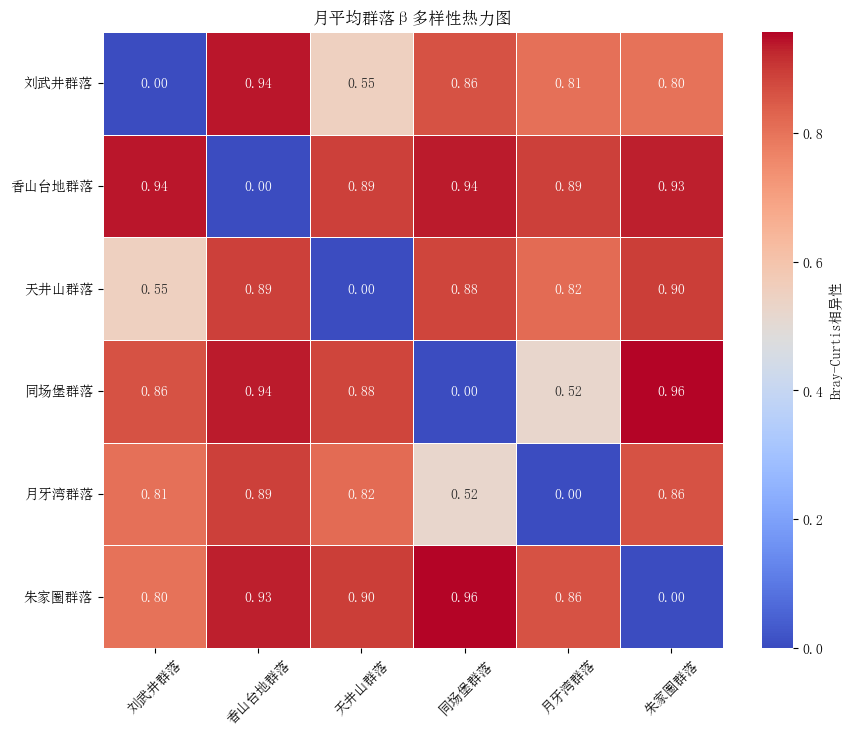

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


图片已保存至：D:\John\生态学\生物多样性指数计算\results\clustermap.pdf


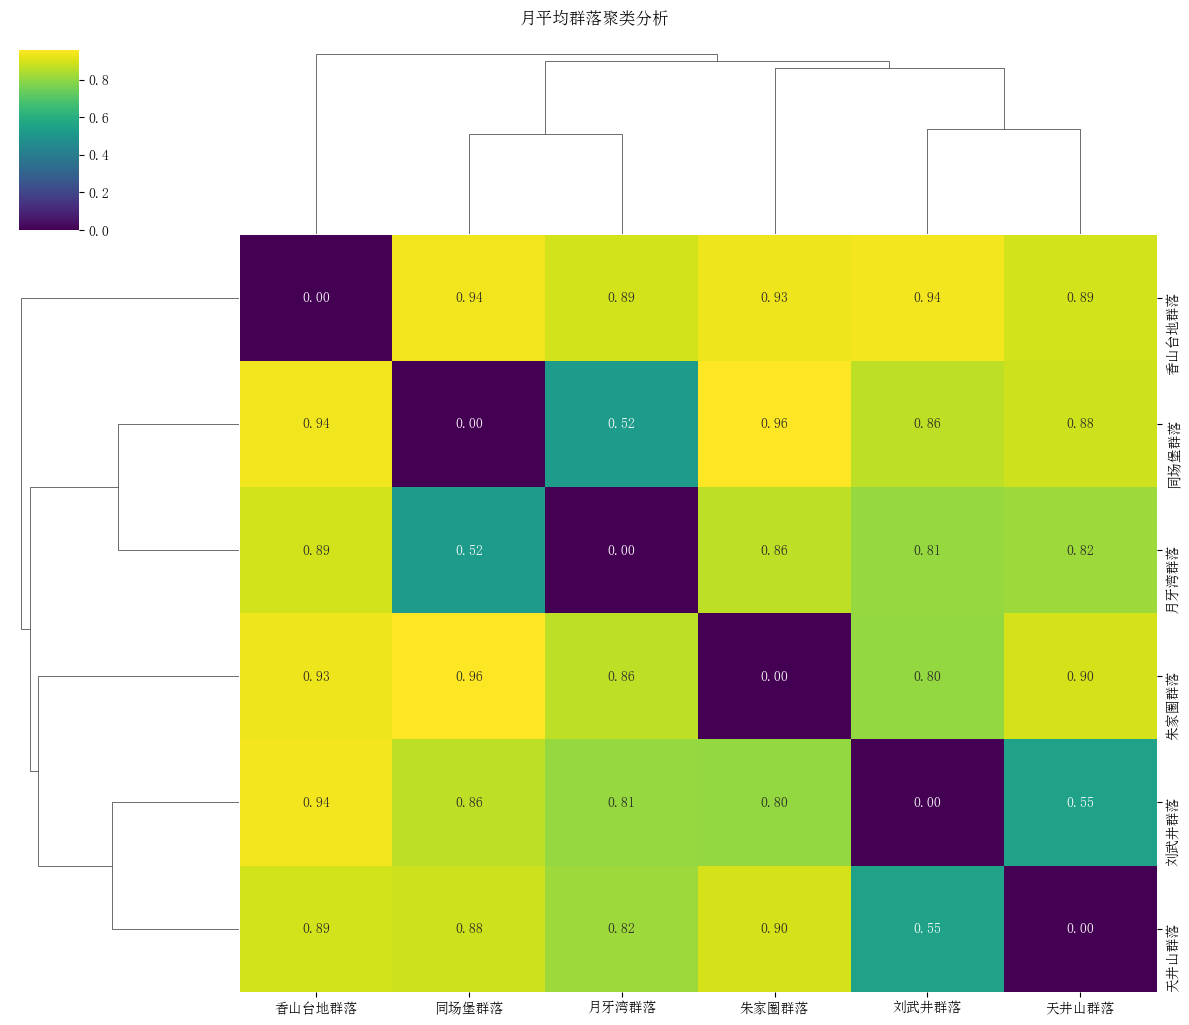

In [72]:
plot_heatmap(
    average_matrix,
    title="月平均群落β多样性热力图",
    save_path="./results/heatmap.png",  # 自动创建results目录
    cmap="coolwarm"
)

plot_clustermap(
    average_matrix,
    title="月平均群落聚类分析",
    save_path="./results/clustermap.pdf",  # 支持PDF格式
    figsize=(12,10),
    cmap="viridis"
)

In [41]:
average_matrix

,刘武井群落,香山台地群落,天井山群落,同场堡群落,月牙湾群落,朱家圈群落
刘武井群落,0.00,0.94,0.55,0.86,0.81,0.80
香山台地群落,0.94,0.00,0.89,0.94,0.89,0.93
天井山群落,0.55,0.89,0.00,0.88,0.82,0.90
同场堡群落,0.86,0.94,0.88,0.00,0.52,0.96
月牙湾群落,0.81,0.89,0.82,0.52,0.00,0.86
朱家圈群落,0.80,0.93,0.90,0.96,0.86,0.00
